![](FBS-with-Trendlines.png)

## Use bagging regression to create an estimator that models my data more closely than polynomial approximations:
<p></p>

![](Polynomial-appoximations-to-FBS-data.png)

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame as DF, Series as Ser
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [5]:
# Read original dataset (will need modification):
path = "all-day-glucose.xlsx"
df0 = pd.read_excel(path).iloc[:, :18]
columns = df0.iloc[0, 0:18]
df0.columns = columns
pd.set_option('display.max_rows', 4)
df0

,Date,FBS,8 AM,9 AM,10 AM,11 AM,12 PM,1 PM,2 PM,3 PM,4 PM,5 PM,6 PM,7 PM,8 PM,9 PM,10 PM,Average by Date
0,Date,FBS,8 AM,9 AM,10 AM,11 AM,12 PM,1 PM,2 PM,3 PM,4 PM,5 PM,6 PM,7 PM,8 PM,9 PM,10 PM,Average by Date
1,2023-11-08,NaN,NaN,138,NaN,NaN,NaN,109,NaN,NaN,NaN,127,NaN,NaN,NaN,124,NaN,124.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,2024-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259,2024-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Extract the FBS feature; drop NaNs and add a numeric "Day" index:
def check_FBS_values(df): 
    fbsvals = df["FBS"].values
    for i in range(len(df)):
        if type(fbsvals[i]) != int or fbsvals[i] <= 0:
            raise ValueError("Invalid FBS \"" + str(fbsvals[i]) + \
                "\" at row " + str(i))
df = df0.iloc[1:, 0:2].dropna() # get rid of headers and nans
df.index = range(len(df))

# Introduce a column showing das from day 0
df = pd.concat([Ser(range(len(df))), df], axis=1)
df.columns = ["Day", "Date", "FBS"]

check_FBS_values(df)

pd.set_option('display.max_rows', 4)
df # last row should show most recent date and FBS

,Day,Date,FBS
0,0,2023-11-09,104
1,1,2023-11-10,108
...,...,...,...
159,159,2024-07-06,78
160,160,2024-07-07,88


In [4]:
# make the data and target arrays:
X = np.array(df["Day"])
y = np.array(df["FBS"])

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def sort_X_and_y(X_, y_):
    i_sorted = np.argsort(X_)

    X_sorted = np.sort(X_)
    y_sorted = np.array([y_[i] for i in i_sorted])
    return X_sorted, y_sorted


In [6]:
# Create training and test sets:
from sklearn.model_selection import train_test_split
X_train_unsrt, X_test_unsrt, y_train_unsrt, y_test_unsrt = train_test_split(
    X, y, test_size=0.25, random_state=42) # identical to the polynomial version

X_train, y_train = sort_X_and_y(X_train_unsrt, y_train_unsrt)
X_test, y_test = sort_X_and_y(X_test_unsrt, y_test_unsrt)

In [7]:
# Create a simple (non-bagged) decision-tree regressor:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3, random_state=0)

# Train the linear model using the training sets
tree.fit(X_train.reshape(-1, 1), y_train)

# Make predictions for linear regression using the testing set
y_pred = tree.predict(X_test.reshape(-1, 1))

# Coefficients for mean squared error. linear regression:
mse = [1, mean_squared_error(y_test, y_pred)]

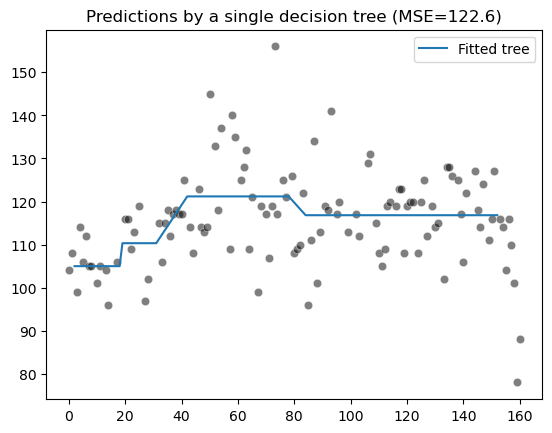

In [8]:
# Plot the regressor's predictions, with mean-squared error:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(
    x=X_train, y=y_train, color="black", alpha=0.5
)
plt.plot(X_test, y_pred, label="Fitted tree")
plt.legend()
_ = plt.title(f"Predictions by a single decision tree (MSE={mse[1]:.4})")

# Bootstrap resampling 
## ("random sampling with replacement")
We will create a function that given `data` and `target` will return a
resampled variation `data_bootstrap` and `target_bootstrap`.

In [9]:
def bootstrap_sample(data, target):
    # Indices corresponding to a sampling with replacement of the same sample
    # size than the original data
    bootstrap_indices = rng.choice(
        np.arange(target.shape[0]),
        size=target.shape[0],
        replace=True,
    )
    # In pandas, we need to use `.iloc` to extract rows using an integer
    # position index:
    data_bootstrap = data.iloc[bootstrap_indices]
    target_bootstrap = target.iloc[bootstrap_indices]
    return data_bootstrap, target_bootstrap

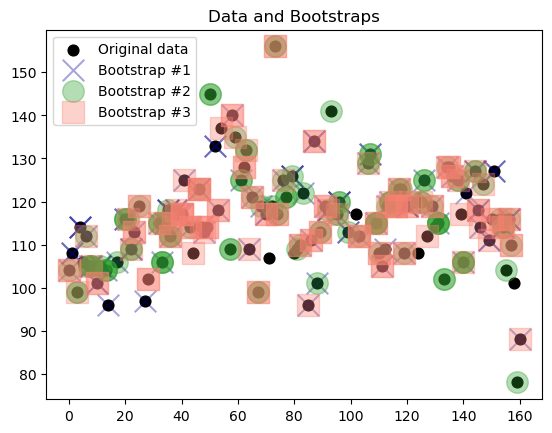

In [10]:
# create a random number generator that will be used to set the randomness
rng = np.random.RandomState(1)

data_train, target_train = DF(X_train), DF(y_train)
data_test, target_test = DF(X_test), DF(y_test)

# Create some bootstraps
n_bootstraps = 3
bootstraps_all = []
for bootstrap_idx in range(n_bootstraps):
    # draw a bootstrap from the original data
    data_bootstrap, target_bootstrap = bootstrap_sample(
        data_train,
        target_train,
    )
    bootstraps_all.append([data_bootstrap, target_bootstrap])

# Compare all data points with those of the bootstraps, on a single plot.
# Different bootstraps are seen to select different sets of points.
scatter_colors = ["darkblue", "tab:green", "salmon"]
markers = ["x", "o", "s"]

plt.scatter(
    data_train, target_train, color="black",
    s=60, alpha=1, label="Original data"
)
for i in range(len(bootstraps_all)):
    plt.scatter(bootstraps_all[i][0], bootstraps_all[i][1],
        color=scatter_colors[i],
        marker=markers[i], s=240,
        alpha=0.35, label=f"Bootstrap #{i+1}"
    )
plt.title("Data and Bootstraps")
plt.legend(loc="upper left")
plt.show()

"Using bootstrap we are able to generate many datasets, all slightly different.
We can fit a decision tree for each of these datasets and they all shall be
slightly different as well."

In [11]:
bag_of_trees = []
for bootstrap_idx in range(n_bootstraps):
    tree = DecisionTreeRegressor(max_depth=3, random_state=0)

    data_bootstrap_sample, target_bootstrap_sample = bootstrap_sample(
        data_train, target_train
    )
    tree.fit(data_bootstrap_sample, target_bootstrap_sample)
    bag_of_trees.append(tree)

Now that we've created a bag of different trees, we can use each of the trees to
predict the samples within the range of data. Their predictions differ slightly.

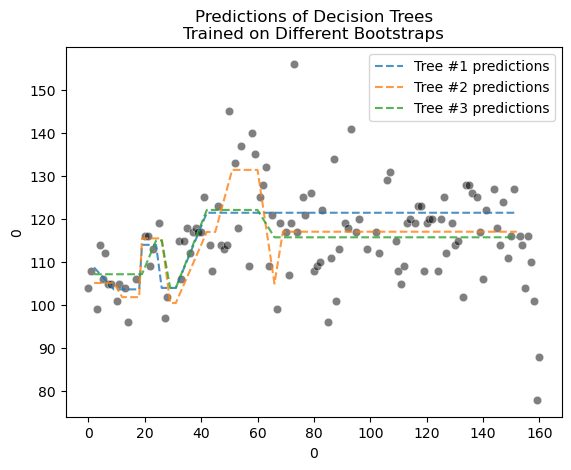

In [12]:
sns.scatterplot(
    x=data_train[0], y=target_train[0], color="black", alpha=0.5
)
for tree_idx, tree in enumerate(bag_of_trees):
    tree_predictions = tree.predict(data_test)
    plt.plot(
        data_test,
        tree_predictions,
        linestyle="--",
        alpha=0.8,
        label=f"Tree #{tree_idx+1} predictions",
    )

plt.legend()
_ = plt.title("Predictions of Decision Trees\nTrained on Different Bootstraps")

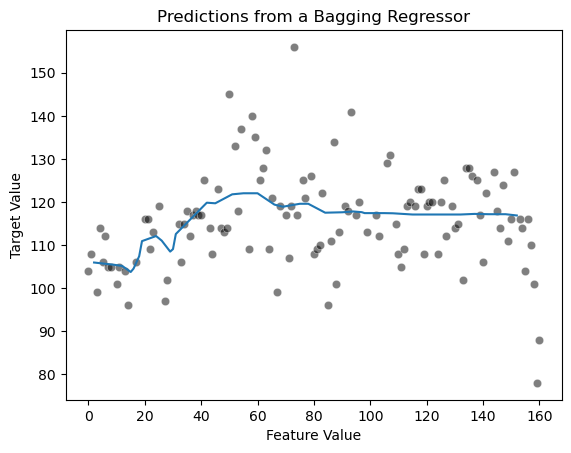

In [13]:
# Bagging in scikit-learn
from sklearn.ensemble import BaggingRegressor

bagged_trees = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=3),
    n_estimators=100,
)
bagged_trees.fit(X_train.reshape(-1, 1), y_train)

sns.scatterplot(
    x=data_train[0], y=target_train[0], color="black", alpha=0.5
)

bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(data_test, bagged_trees_predictions)
plt.xlabel('Feature Value')
plt.ylabel('Target Value')

_ = plt.title("Predictions from a Bagging Regressor")

Using the `bagged_trees.estimators_`attribute to access each estimator, we compare the based model predictions with their average.

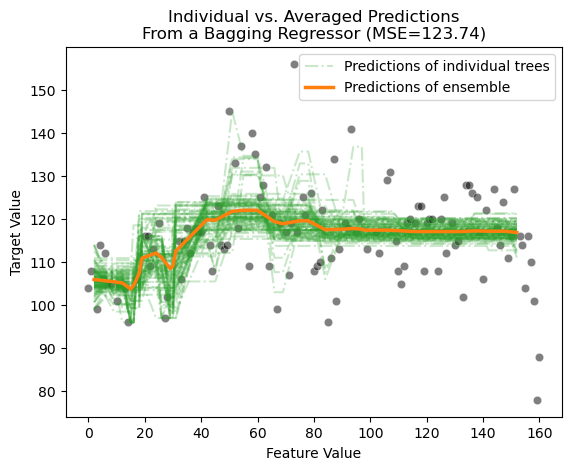

In [14]:
for tree_idx, tree in enumerate(bagged_trees.estimators_):
    label = "Predictions of individual trees" if tree_idx == 0 else None
    # we convert `data_test` into a NumPy array to avoid a warning raised in scikit-learn
    tree_predictions = tree.predict(data_test.to_numpy())
    plt.plot(
        data_test,
        tree_predictions,
        linestyle="-.",
        alpha=0.25,
        color="tab:green",
        label=label,
    )

sns.scatterplot(
    x=data_train[0], y=target_train[0], color="black", alpha=0.5
)

bagged_trees_predictions = bagged_trees.predict(data_test)
mse_bag = [1, mean_squared_error(target_test, bagged_trees_predictions)]
plt.plot(
    data_test,
    bagged_trees_predictions,
    color="tab:orange",
    label="Predictions of ensemble",
    linewidth=2.5,
)
plt.xlabel('Feature Value')
plt.ylabel('Target Value')
plt.legend()
_ = plt.title("Individual vs. Averaged Predictions\n" + \
              f"From a Bagging Regressor (MSE={mse_bag[1]:6.5})")

In [15]:
print("Most recent date:", df.iloc[-1, 1])
print("Most recent FBS:", df.iloc[-1, 2])

Most recent date: 2024-07-07
Most recent FBS: 88
